# Image Matching Challenge 2024 - BaseLine

## Structure from motion

Structure from Motion (SfM) is the name given to the procedure of reconstructing a 3D scene and simultaneously obtaining the camera poses of a camera w.r.t. the given scene. This means that, as the name suggests, we are creating the entire rigid structure from a set of images with different view points (or equivalently a camera in motion).

In this competition, the important aspect of SfM we are interested in is obtaining the camera poses of where each image was taken, described by a rotation matrix and translation vector from the origin. These are the objects that will be scored for this competition!

<br>
<img src="https://i.ibb.co/fdbYhNW/sfm.png">



## Import Libraries

In [1]:
import os
import gc
from pathlib import Path
from time import time, sleep
from copy import deepcopy
from typing import Any
import itertools
from IPython.display import clear_output
from collections import defaultdict
from fastprogress import progress_bar
from hloc.utils.database import COLMAPDatabase
from tqdm import tqdm

import cv2
import h5py
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import Tensor as T
import torch.nn.functional as F

from transformers import AutoImageProcessor, AutoModel

import pycolmap

import kornia as K
import kornia.feature as KF

from lightglue import match_pair
from lightglue import LightGlue, ALIKED
from lightglue.utils import load_image, rbd

from packages.coolmap_db.database import *
from packages.coolmap_db.h5_to_db import *

## Device

In [2]:
device = K.utils.get_cuda_device_if_available(0)
print(device)

cuda:0


## Data

In [3]:
root_dir = Path("/mnt/d/Projects_D/Image_Matching_Challenge_2024/")
root_dir

PosixPath('/mnt/d/Projects_D/Image_Matching_Challenge_2024')

In [4]:
data_dir = Path(root_dir, "data/image-matching-challenge-2024/")
data_dir

PosixPath('/mnt/d/Projects_D/Image_Matching_Challenge_2024/data/image-matching-challenge-2024')

## Utils

In [5]:
def arr_to_str(a):
    """Returns ;-separated string representing the input"""
    return ";".join([str(x) for x in a.reshape(-1)])

In [6]:
def load_torch_image(file_name: Path | str, device=torch.device("cpu")):
    """Loads an image and adds batch dimension"""
    img = K.io.load_image(file_name, K.io.ImageLoadType.RGB32, device=device)[None, ...]
    return img

## Finding Similar Images

We use [DINOv2](https://arxiv.org/pdf/2304.07193.pdf) to obtain normalized image embeddings. We then use the distance between these embeddings to find similar images. We keep images below a certain threshold distance. For images with less than a set minimum number of pairs, the closest ones are kept instead.

In [7]:
def embed_images(image_paths: list[Path], model_name: str, device: torch.device = torch.device("cpu")):
    """
    Compute image embeddings using a pretrained model
    Args:
        image_paths (list[Path]): image paths
        model_name (str): model name
        device (torch.device, optional): Defaults to torch.device("cpu").

    Returns:
        tensor: embeddings of size (len(image_paths), embedding_size)
    """

    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).eval().to(device)

    embeddings = []

    for i, path in tqdm(enumerate(image_paths), desc="Global descriptors"):
        image = load_torch_image(path)
    
        with torch.inference_mode():
            inputs = processor(images=image, return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs) # last_hidden_state and pooled
    
            # Max pooling over all the hidden states but the first (starting token)
            # To obtain a tensor of shape [1, output_dim]
            # We normalize so that distances are computed in a better fashion later
            embedding = F.normalize(outputs.last_hidden_state[:,1:].max(dim=1)[0], dim=-1, p=2)
    
        embeddings.append(embedding.detach().cpu())
    return torch.cat(embeddings, dim=0)

In [8]:
def get_pairs_exhaustive(lst: list[Any]) -> list[tuple[int, int]]:
    """
    Obtains all possible index pairs of a list
    
    Args:
        lst (list[Any]): list of elements
    
    Returns:
        list[tuple[int, int]]: list of all possible index pairs
    """
    return list(itertools.combinations(range(len(lst)), 2))  

In [9]:
def get_image_pairs(paths: list[Path], model_name: str, similarity_threshold: float = 0.6, 
                    tolerance: int = 1000, min_matches: int = 20, exhaustive_if_less: int = 20,
                    p: float = 2.0, device: torch.device = torch.device("cpu")) -> list[tuple[int, int]]:
    """
    Obtains pairs of images that are similar
    Args:
        paths (list[Path]): list of image paths
        model_name (str): model name
        similarity_threshold (float, optional): Defaults to 0.6.
        tolerance (int, optional): Defaults to 1000.
        min_matches (int, optional): Defaults to 20.
        exhaustive_if_less (int, optional): Defaults to 20.
        p (float, optional): Defaults to 2.0.
        device (torch.device, optional): Defaults to torch.device("cpu").

    Returns:
        list[tuple[int, int]]: list of image pairs
    """

    if len(paths) <= exhaustive_if_less:
        return get_pairs_exhaustive(paths)

    matches = []

    # Embed images and compute distances for filtering
    embeddings = embed_images(paths, model_name)
    distances = torch.cdist(embeddings, embeddings, p=p)

    # Remove pairs above similarity threshold (if enough)
    mask = distances <= similarity_threshold
    image_indices = np.arange(len(paths))

    for current_image_index in range(len(paths)):
        mask_row = mask[current_image_index]
        indices_to_match = image_indices[mask_row]

        # We don't have enough matches below the threshold, we pick most similar ones
        if len(indices_to_match) < min_matches:
            indices_to_match = np.argsort(distances[current_image_index])[:min_matches]

        for other_image_index in indices_to_match:
            # Skip an image matching itself
            if other_image_index == current_image_index:
                continue

            # We need to check if we are below a certain distance tolerance 
            # since for images that don't have enough matches, we picked
            # the most similar ones (which could all still be very different 
            # to the image we are analyzing)
            if distances[current_image_index, other_image_index] < tolerance:
                # Add the pair in a sorted manner to avoid redundancy
                matches.append(tuple(sorted((current_image_index, other_image_index.item()))))

    return sorted(list(set(matches)))

### Example

In [10]:
images_list = list(Path(data_dir / "test/church/images/").glob("*.png"))[:10]
index_pairs = get_image_pairs(images_list, Path(root_dir, "models/dinov2_base"))
print(index_pairs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


## Computing keypoints

To determine the location of each camera, it’s essential to establish a connection between images. This is achieved by identifying important keypoints within the images and then matching these keypoints between pairs of images. While there are several techniques for keypoint extraction, [SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) is one of the more conventional methods. Nonetheless, there are modern and more efficient alternatives available today, such as [ALIKED](https://arxiv.org/abs/2304.03608), which is the keypoint extraction technique employed in the current solution.

<br>

<img src="https://github.com/Shiaoming/ALIKED/blob/main/assets/net.png?raw=true" width="1500">

### ALIKED

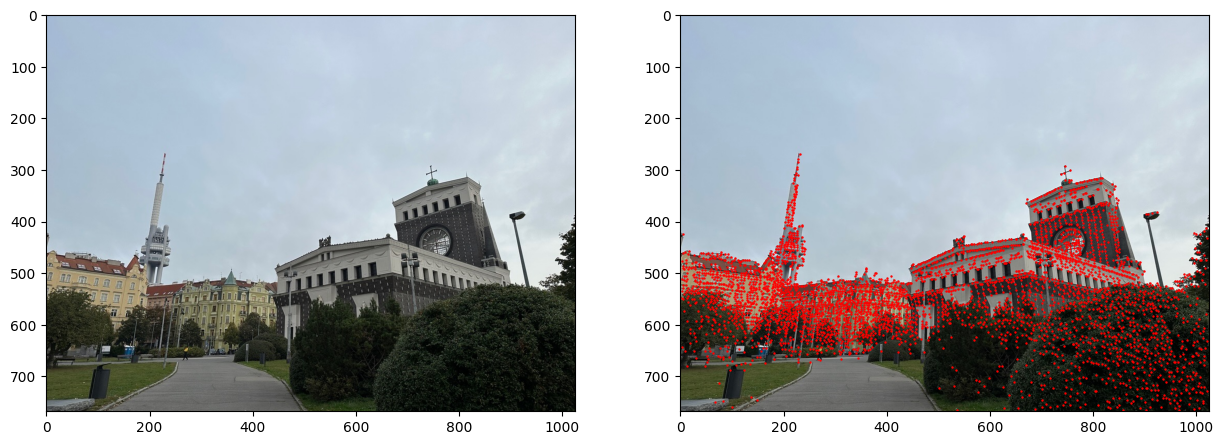

In [11]:
dtype = torch.float32 # ALIKED has issues with float16

extractor = ALIKED(
    max_num_keypoints=4096,
    detection_threshold=0.01,
    resize=1024,
).eval().to(device, dtype)

path = images_list[0]
image = load_torch_image(path, device=device).to(dtype)
features = extractor.extract(image)


fig, ax = plt.subplots(1, 2, figsize=(15, 30))
ax[0].imshow(image[0, ...].permute(1,2,0).cpu())
ax[1].imshow(image[0, ...].permute(1,2,0).cpu())
ax[1].scatter(features["keypoints"][0, :, 0].cpu(), features["keypoints"][0, :, 1].cpu(), s=0.5, c="red")

del extractor

### Extract Keypoints

In [12]:
def detect_keypoints( paths: list[Path], feature_dir: Path, num_features: int = 4096, resize_to: int = 1024, device: torch.device = torch.device("cpu"),
) -> None:
    """Detects the keypoints in a list of images with ALIKED
    
    Stores them in feature_dir/keypoints.h5 and feature_dir/descriptors.h5
    to be used later with LightGlue
    
    Args:
        paths (list[Path]): list of image paths
        feature_dir (Path): directory to store the keypoints and descriptors
        num_features (int, optional): Defaults to 4096.
        resize_to (int, optional): Defaults to 1024.
        device (torch.device, optional): Defaults to torch.device("cpu").
        
    Returns:
        None
    """
    
    dtype = torch.float32 # ALIKED has issues with float16

    extractor = ALIKED(
        max_num_keypoints=num_features,
        detection_threshold=0.01,
        resize=resize_to
    ).eval().to(device, dtype)

    feature_dir.mkdir(parents=True, exist_ok=True)

    with h5py.File(feature_dir / "keypoints.h5", mode="w") as f_keypoints, \
            h5py.File(feature_dir / "descriptors.h5", mode="w") as f_descriptors:

        for path in tqdm(paths, desc="Computing keypoints"):
            key = path.name

            with torch.inference_mode():
                image = load_torch_image(path, device=device).to(dtype)
                features = extractor.extract(image)

                f_keypoints[key] = features["keypoints"].squeeze().detach().cpu().numpy()
                f_descriptors[key] = features["descriptors"].squeeze().detach().cpu().numpy()

In [13]:
feature_dir = Path("./sample_features")

In [14]:
detect_keypoints(images_list, feature_dir)

Computing keypoints: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


## Match and compute keypoint distances

We will compare the keypoints of the images to find the matches between them. We will use [LightGlue](https://arxiv.org/abs/2306.13643) to match keypoints and compute the distances between them.

<br>
<img src="https://i.ibb.co/YNcCgW2/lightglue.jpg" width="1500">

### LightGlue

In [15]:
matcher_params = {
    "width_confidence": -1,
    "depth_confidence": -1,
    "mp": True if 'cuda' in str(device) else False,
}

In [16]:
matcher = KF.LightGlueMatcher("aliked", matcher_params).eval().to(device)

Loaded LightGlue model


In [17]:
with h5py.File(feature_dir / "keypoints.h5", mode="r") as f_keypoints, h5py.File(feature_dir / "descriptors.h5", mode="r") as f_descriptors:
    idx1, idx2 = index_pairs[0]
    key1, key2 = images_list[idx1].name, images_list[idx2].name

    keypoints1 = torch.from_numpy(f_keypoints[key1][...]).to(device)
    keypoints2 = torch.from_numpy(f_keypoints[key2][...]).to(device)
    print("Keypoints:", keypoints1.shape, keypoints2.shape)
    descriptors1 = torch.from_numpy(f_descriptors[key1][...]).to(device)
    descriptors2 = torch.from_numpy(f_descriptors[key2][...]).to(device)
    print("Descriptors:", descriptors1.shape, descriptors2.shape)

    with torch.inference_mode():
        distances, indices = matcher(
            descriptors1,
            descriptors2,
            KF.laf_from_center_scale_ori(keypoints1[None]),
            KF.laf_from_center_scale_ori(keypoints2[None]),
        )

Keypoints: torch.Size([4096, 2]) torch.Size([4096, 2])
Descriptors: torch.Size([4096, 128]) torch.Size([4096, 128])


In [18]:
print(distances.shape, indices.shape)

torch.Size([1450, 1]) torch.Size([1450, 2])


### Keypoint Distances

In [19]:
def keypoint_distances(
        paths: list[Path],
        index_pairs: list[tuple[int, int]],
        feature_dir: Path,
        min_matches: int = 15,
        verbose: bool = True,
        device: torch.device = torch.device("cpu"),
) -> None:
    """Computes distances between keypoints of images.
    
    Stores output at feature_dir/matches.h5
    """

    matcher_params = {
        "width_confidence": -1,
        "depth_confidence": -1,
        "mp": True if 'cuda' in str(device) else False,
    }
    matcher = KF.LightGlueMatcher("aliked", matcher_params).eval().to(device)

    with h5py.File(feature_dir / "keypoints.h5", mode="r") as f_keypoints, \
            h5py.File(feature_dir / "descriptors.h5", mode="r") as f_descriptors, \
            h5py.File(feature_dir / "matches.h5", mode="w") as f_matches:

        for idx1, idx2 in tqdm(index_pairs, desc="Computing keypoing distances"):
            key1, key2 = paths[idx1].name, paths[idx2].name

            keypoints1 = torch.from_numpy(f_keypoints[key1][...]).to(device)
            keypoints2 = torch.from_numpy(f_keypoints[key2][...]).to(device)
            descriptors1 = torch.from_numpy(f_descriptors[key1][...]).to(device)
            descriptors2 = torch.from_numpy(f_descriptors[key2][...]).to(device)

            with torch.inference_mode():
                distances, indices = matcher(
                    descriptors1,
                    descriptors2,
                    KF.laf_from_center_scale_ori(keypoints1[None]),
                    KF.laf_from_center_scale_ori(keypoints2[None]),
                )

            # We have matches to consider
            n_matches = len(indices)
            if n_matches:
                if verbose:
                    print(f"{key1}-{key2}: {n_matches} matches")
                # Store the matches in the group of one image
                if n_matches >= min_matches:
                    group  = f_matches.require_group(key1)
                    group.create_dataset(key2, data=indices.detach().cpu().numpy().reshape(-1, 2))

In [35]:
keypoint_distances(images_list, index_pairs, feature_dir, verbose=False)

Loaded LightGlue model


Computing keypoing distances: 100%|██████████| 45/45 [05:11<00:00,  6.91s/it]


## RANSAC

We have matched key points between images. This is described by a fundamental matirx denoted by F. In epipolar geometry, with homogeneous image coordinates, x and x′, of corresponding points in a stereo image pair, Fx describes a line (an epipolar line) on which the corresponding point x′ on the other image must lie. That means, for all pairs of corresponding points,  x′Fx=0 holds. This is known as epipolar constraint or correspondance condition (or Longuet-Higgins equation), and is solved via the eight-point algorithm.

<br>
<img src="https://cmsc426.github.io/assets/sfm/epipole1.png">
<br>

Since the keypoint correspondences are computed using feature descriptors, the data is bound to be noisy and (in general) contains several outliers. Thus, to remove these outliers, we use a RANSAC algorithm to find the best possible fundamental matrix. **RANSAC** is a robust method for estimating the parameters of a mathematical model from a set of observed data that contains outliers. It is an iterative method that estimates the model parameters from a subset of the data, the so-called inliers. The model is then evaluated on the remaining data, and the process is repeated until the best model is found.

<br>
<img src="https://cmsc426.github.io/assets/sfm/ransac.png">

In [20]:
def import_into_colmap(path: Path, feature_dir: Path, database_path: str = "colmap.db",) -> None:
    """Adds keypoints into colmap"""
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, path, "", "simple-pinhole", single_camera)
    add_matches(db, feature_dir, fname_to_id)
    db.commit()

In [22]:
db_path = Path(feature_dir, "colmap.db")
image_dir = images_list[0].parent
import_into_colmap(image_dir, feature_dir, db_path)
pycolmap.match_exhaustive(db_path)

100%|██████████| 10/10 [00:00<00:00, 26.07it/s]
45it [00:00, 1749.12it/s]             
I20240406 14:51:42.730142  5407 misc.cc:198] 
Exhaustive feature matching
I20240406 14:51:42.734355  5407 feature_matching.cc:231] Matching block [1/1, 1/1]
I20240406 14:51:42.872023  5407 feature_matching.cc:46]  in 0.138s
I20240406 14:51:42.902078  5407 timer.cc:91] Elapsed time: 0.003 [minutes]


## Sparse Reconstruction

We have the camera poses and the matches between the images. We can now construct the scenes and obtain camera positions. We will use pycolmap's incremental reconstruction algorithm that starts from two pairs of images and continually adds more and more images to the scene, resulting in a reconstructed scene with camera information.

In [23]:
mapper_options = pycolmap.IncrementalPipelineOptions()
mapper_options.min_model_size = 3
mapper_options.max_num_models = 2

maps = pycolmap.incremental_mapping(
    database_path=db_path,
    image_path=image_dir,
    output_path=feature_dir / "incremental_pipeline_outputs",
    options=mapper_options,
)

I20240406 14:51:44.316339  5486 misc.cc:198] 
Loading database
I20240406 14:51:44.333158  5486 database_cache.cc:54] Loading cameras...
I20240406 14:51:44.334038  5486 database_cache.cc:64]  10 in 0.001s
I20240406 14:51:44.334074  5486 database_cache.cc:72] Loading matches...
I20240406 14:51:44.341095  5486 database_cache.cc:78]  45 in 0.007s
I20240406 14:51:44.341137  5486 database_cache.cc:94] Loading images...
I20240406 14:51:44.350998  5486 database_cache.cc:143]  10 in 0.010s (connected 10)
I20240406 14:51:44.351055  5486 database_cache.cc:154] Building correspondence graph...
I20240406 14:51:44.354703  5486 database_cache.cc:190]  in 0.004s (ignored 0)
I20240406 14:51:44.354804  5486 timer.cc:91] Elapsed time: 0.000 [minutes]
I20240406 14:51:44.359656  5486 misc.cc:198] 
Finding good initial image pair
I20240406 14:51:44.596357  5486 misc.cc:198] 
Initializing with image pair #5 and #10
I20240406 14:51:44.598922  5486 misc.cc:198] 
Global bundle adjustment
I20240406 14:51:44.6981

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  4.231913e+03    0.00e+00    1.70e+05   0.00e+00   0.00e+00  1.00e+04        0    1.47e-03    4.10e-03
   1  1.228479e+04   -8.05e+03    1.70e+05   1.81e+02  -2.20e+00  5.00e+03        1    2.41e-03    6.55e-03
   2  5.309491e+03   -1.08e+03    1.70e+05   1.62e+02  -3.09e-01  1.25e+03        1    9.28e-04    7.50e-03
   3  1.747724e+03    2.48e+03    8.73e+04   1.02e+02   9.05e-01  2.66e+03        1    1.72e-03    9.25e-03
   4  7.068158e+02    1.04e+03    4.74e+04   6.32e+01   9.55e-01  7.99e+03        1    1.70e-03    1.10e-02
   5  6.697176e+02    3.71e+01    1.88e+04   5.93e+01   1.59e-01  6.07e+03        1    1.70e-03    1.27e-02
   6  4.543037e+02    2.15e+02    1.44e+04   3.34e+01   9.20e-01  1.48e+04        1    1.64e-03    1.43e-02
   7  5.568587e+02   -1.03e+02    1.44e+04   4.78e+01  -1.36e+00  7.42e+03        1    8.81e-04    1.52e-02
   8  4.204702e+02    3.38e+

I20240406 14:51:44.869326  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:44.869395  5486 bundle_adjustment.cc:942] 
    Residuals : 11484
   Parameters : 7244
   Iterations : 13
         Time : 0.088208 [s]
 Initial cost : 0.329253 [px]
   Final cost : 0.276705 [px]
  Termination : Convergence

I20240406 14:51:44.872715  5486 incremental_mapper.cc:78] => Merged observations: 16
I20240406 14:51:44.872747  5486 incremental_mapper.cc:79] => Completed observations: 50
I20240406 14:51:44.872753  5486 incremental_mapper.cc:81] => Filtered observations: 28
I20240406 14:51:44.872756  5486 incremental_mapper.cc:90] => Changed observations: 0.016371
I20240406 14:51:44.921063  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:44.921126  5486 bundle_adjustment.cc:942] 
    Residuals : 11528
   Parameters : 7232
   Iterations : 7
         Time : 0.0451109 [s]
 Initial cost : 0.317308 [px]
   Final cost : 0.302403 [px]
  Termi

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.064755e+03    0.00e+00    2.22e+02   0.00e+00   0.00e+00  1.00e+04        0    2.88e-03    6.92e-03
   1  1.064211e+03    5.44e-01    1.36e+00   2.04e-01   1.00e+00  3.00e+04        1    6.62e-03    1.36e-02
   2  1.064209e+03    1.53e-03    1.15e+00   3.14e-01   1.00e+00  9.00e+04        1    6.00e-03    1.96e-02
   3  1.064207e+03    2.10e-03    2.20e+00   5.45e-01   1.01e+00  2.70e+05        1    6.17e-03    2.58e-02
   4  1.064205e+03    1.86e-03    4.53e+00   7.35e-01   1.01e+00  8.10e+05        1    6.67e-03    3.26e-02
   5  1.064205e+03    5.50e-04    2.29e+00   5.20e-01   1.02e+00  2.43e+06        1    6.79e-03    3.94e-02
   6  1.064204e+03    3.92e-05    1.59e+00   1.58e-01   1.03e+00  7.29e+06        1    7.02e-03    4.65e-02
   7  1.064204e+03    6.34e-07    1.84e-01   2.12e-02   1.04e+00  2.19e+07        1    6.51e-03    5.31e-02
   8  1.064204e+03    3.44e-

I20240406 14:51:45.088243  5486 misc.cc:205] 
Pose refinement report
----------------------
I20240406 14:51:45.088297  5486 bundle_adjustment.cc:942] 
    Residuals : 2896
   Parameters : 7
   Iterations : 7
         Time : 0.00510001 [s]
 Initial cost : 0.514585 [px]
   Final cost : 0.37731 [px]
  Termination : Convergence

I20240406 14:51:45.089447  5486 incremental_mapper.cc:40] => Continued observations: 1403
I20240406 14:51:45.091924  5486 incremental_mapper.cc:43] => Added observations: 528
I20240406 14:51:45.173871  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:45.173934  5486 bundle_adjustment.cc:942] 
    Residuals : 15394
   Parameters : 7863
   Iterations : 8
         Time : 0.0775912 [s]
 Initial cost : 0.318502 [px]
   Final cost : 0.302717 [px]
  Termination : Convergence

I20240406 14:51:45.179111  5486 incremental_mapper.cc:78] => Merged observations: 191
I20240406 14:51:45.179154  5486 incremental_mapper.cc:79] => Completed observ

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.040637e+03    0.00e+00    3.69e+02   0.00e+00   0.00e+00  1.00e+04        0    3.91e-03    9.29e-03
   1  2.032099e+03    8.54e+00    2.94e+00   5.62e-01   1.00e+00  3.00e+04        1    9.12e-03    1.85e-02
   2  2.032087e+03    1.18e-02    1.98e+00   4.52e-01   1.00e+00  9.00e+04        1    8.08e-03    2.66e-02
   3  2.032080e+03    6.74e-03    5.49e+00   6.60e-01   1.01e+00  2.70e+05        1    8.74e-03    3.53e-02
   4  2.032076e+03    4.12e-03    8.32e+00   9.84e-01   1.02e+00  8.10e+05        1    9.22e-03    4.46e-02
   5  2.032075e+03    8.81e-04    2.78e+00   5.88e-01   1.03e+00  2.43e+06        1    9.67e-03    5.44e-02
   6  2.032075e+03    4.53e-05    7.70e-01   1.48e-01   1.04e+00  7.29e+06        1    9.89e-03    6.43e-02
   7  2.032075e+03    6.06e-07    1.33e-01   1.76e-02   1.05e+00  2.19e+07        1    1.02e-02    7.46e-02
   8  2.032075e+03    3.55e-

I20240406 14:51:45.308020  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:45.308130  5486 bundle_adjustment.cc:942] 
    Residuals : 15444
   Parameters : 7761
   Iterations : 9
         Time : 0.084594 [s]
 Initial cost : 0.363499 [px]
   Final cost : 0.362735 [px]
  Termination : Convergence

I20240406 14:51:45.311683  5486 incremental_mapper.cc:175] => Completed observations: 0
I20240406 14:51:45.312642  5486 incremental_mapper.cc:178] => Merged observations: 0
I20240406 14:51:45.313524  5486 incremental_mapper.cc:160] => Filtered observations: 0
I20240406 14:51:45.313561  5486 incremental_mapper.cc:119] => Changed observations: 0.000000
I20240406 14:51:45.313576  5486 incremental_mapper.cc:167] => Filtered images: 0
I20240406 14:51:45.361374  5486 misc.cc:198] 
Registering image #8 (5)
I20240406 14:51:45.361431  5486 incremental_mapper.cc:495] => Image sees 1369 / 3025 points
I20240406 14:51:45.403553  5486 misc.cc:205] 
Pose refinement report


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.974437e+03    0.00e+00    3.19e+02   0.00e+00   0.00e+00  1.00e+04        0    6.41e-03    1.56e-02
   1  3.946615e+03    2.78e+01    2.50e+00   1.44e+00   1.00e+00  3.00e+04        1    1.51e-02    3.08e-02
   2  3.946589e+03    2.66e-02    2.85e+00   1.44e+00   1.01e+00  9.00e+04        1    1.42e-02    4.51e-02
   3  3.946584e+03    5.29e-03    1.70e+00   1.08e+00   1.01e+00  2.70e+05        1    1.38e-02    5.89e-02
   4  3.946582e+03    1.31e-03    1.96e+00   1.15e+00   1.02e+00  8.10e+05        1    1.46e-02    7.36e-02
   5  3.946582e+03    3.91e-04    1.99e+00   8.50e-01   1.05e+00  2.43e+06        1    1.38e-02    8.74e-02
   6  3.946582e+03    3.61e-05    1.64e+00   2.95e-01   1.07e+00  7.29e+06        1    1.42e-02    1.02e-01
   7  3.946582e+03    1.05e-06    2.08e-01   5.27e-02   1.08e+00  2.19e+07        1    1.37e-02    1.15e-01
   8  3.946582e+03    1.51e-

I20240406 14:51:45.845141  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:45.845201  5486 bundle_adjustment.cc:942] 
    Residuals : 21402
   Parameters : 9868
   Iterations : 9
         Time : 0.128659 [s]
 Initial cost : 0.430934 [px]
   Final cost : 0.429421 [px]
  Termination : Convergence

I20240406 14:51:45.848423  5486 incremental_mapper.cc:175] => Completed observations: 0
I20240406 14:51:45.849201  5486 incremental_mapper.cc:178] => Merged observations: 0
I20240406 14:51:45.849997  5486 incremental_mapper.cc:160] => Filtered observations: 2
I20240406 14:51:45.850025  5486 incremental_mapper.cc:119] => Changed observations: 0.000187
I20240406 14:51:45.850042  5486 incremental_mapper.cc:167] => Filtered images: 0
I20240406 14:51:45.886020  5486 misc.cc:198] 
Registering image #3 (6)
I20240406 14:51:45.886070  5486 incremental_mapper.cc:495] => Image sees 1744 / 3281 points
I20240406 14:51:45.947163  5486 misc.cc:205] 
Pose refinement report


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.303270e+03    0.00e+00    7.48e+02   0.00e+00   0.00e+00  1.00e+04        0    7.27e-03    1.77e-02
   1  6.263387e+03    3.99e+01    1.87e+00   1.22e+00   1.00e+00  3.00e+04        1    1.83e-02    3.60e-02
   2  6.263382e+03    5.01e-03    1.85e+00   2.74e-01   9.96e-01  9.00e+04        1    1.75e-02    5.36e-02
   3  6.263381e+03    1.14e-03    1.26e+00   6.67e-01   1.00e+00  2.70e+05        1    1.98e-02    7.34e-02
   4  6.263380e+03    9.46e-04    1.97e+00   1.09e+00   1.02e+00  8.10e+05        1    1.92e-02    9.26e-02
   5  6.263380e+03    3.25e-04    1.82e+00   8.47e-01   1.04e+00  2.43e+06        1    1.82e-02    1.11e-01
   6  6.263380e+03    2.97e-05    1.98e+00   2.95e-01   1.06e+00  7.29e+06        1    1.82e-02    1.29e-01
   7  6.263380e+03    7.55e-07    1.52e-01   4.95e-02   1.07e+00  2.19e+07        1    1.84e-02    1.48e-01
   8  6.263380e+03    8.15e-

I20240406 14:51:46.568825  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:46.568908  5486 bundle_adjustment.cc:942] 
    Residuals : 27514
   Parameters : 11432
   Iterations : 9
         Time : 0.166899 [s]
 Initial cost : 0.478637 [px]
   Final cost : 0.47712 [px]
  Termination : Convergence

I20240406 14:51:46.573005  5486 incremental_mapper.cc:175] => Completed observations: 1
I20240406 14:51:46.574004  5486 incremental_mapper.cc:178] => Merged observations: 0
I20240406 14:51:46.575002  5486 incremental_mapper.cc:160] => Filtered observations: 2
I20240406 14:51:46.575031  5486 incremental_mapper.cc:119] => Changed observations: 0.000218
I20240406 14:51:46.575043  5486 incremental_mapper.cc:167] => Filtered images: 0
I20240406 14:51:46.612736  5486 misc.cc:198] 
Registering image #4 (7)
I20240406 14:51:46.612771  5486 incremental_mapper.cc:495] => Image sees 1645 / 2230 points
I20240406 14:51:46.659396  5486 misc.cc:205] 
Pose refinement report


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.349947e+03    0.00e+00    8.87e+02   0.00e+00   0.00e+00  1.00e+04        0    9.14e-03    2.39e-02
   1  8.316350e+03    3.36e+01    3.62e+00   1.47e+00   1.00e+00  3.00e+04        1    2.28e-02    4.67e-02
   2  8.316327e+03    2.29e-02    3.54e+00   1.26e+00   1.00e+00  9.00e+04        1    2.07e-02    6.74e-02
   3  8.316317e+03    9.83e-03    2.36e+00   1.30e+00   1.00e+00  2.70e+05        1    2.21e-02    8.95e-02
   4  8.316310e+03    7.18e-03    4.91e+00   1.70e+00   1.02e+00  8.10e+05        1    2.14e-02    1.11e-01
   5  8.316307e+03    2.42e-03    2.97e+00   1.30e+00   1.03e+00  2.43e+06        1    2.16e-02    1.33e-01
   6  8.316307e+03    2.18e-04    1.80e+00   4.46e-01   1.05e+00  7.29e+06        1    2.29e-02    1.56e-01
   7  8.316307e+03    5.13e-06    7.59e-01   7.19e-02   1.06e+00  2.19e+07        1    2.16e-02    1.77e-01
   8  8.316307e+03    4.95e-

I20240406 14:51:47.150300  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:47.150357  5486 bundle_adjustment.cc:942] 
    Residuals : 32332
   Parameters : 12186
   Iterations : 9
         Time : 0.198523 [s]
 Initial cost : 0.508189 [px]
   Final cost : 0.507165 [px]
  Termination : Convergence

I20240406 14:51:47.155985  5486 incremental_mapper.cc:175] => Completed observations: 1
I20240406 14:51:47.157490  5486 incremental_mapper.cc:178] => Merged observations: 0
I20240406 14:51:47.158738  5486 incremental_mapper.cc:160] => Filtered observations: 1
I20240406 14:51:47.158785  5486 incremental_mapper.cc:119] => Changed observations: 0.000124
I20240406 14:51:47.158802  5486 incremental_mapper.cc:167] => Filtered images: 0
I20240406 14:51:47.200634  5486 misc.cc:198] 
Registering image #9 (8)
I20240406 14:51:47.200683  5486 incremental_mapper.cc:495] => Image sees 598 / 829 points
I20240406 14:51:47.279848  5486 misc.cc:205] 
Pose refinement report
-

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  5.486426e+04    0.00e+00    2.40e+04   0.00e+00   0.00e+00  1.00e+04        0    1.09e-02    2.65e-02
   1  2.790616e+04    2.70e+04    3.55e+04   6.81e+01   9.11e-01  2.24e+04        1    2.73e-02    5.39e-02
   2  2.616272e+04    1.74e+03    4.07e+03   4.53e+01   9.08e-01  4.89e+04        1    2.41e-02    7.81e-02
   3  2.610181e+04    6.09e+01    2.94e+02   1.11e+01   9.22e-01  1.23e+05        1    2.49e-02    1.03e-01
   4  2.609912e+04    2.69e+00    2.93e+02   1.06e+01   7.79e-01  1.49e+05        1    2.46e-02    1.28e-01
   5  2.609840e+04    7.20e-01    2.32e+02   1.02e+01   9.17e-01  3.54e+05        1    2.39e-02    1.52e-01
   6  2.609810e+04    2.99e-01    2.28e+02   1.02e+01   9.53e-01  1.06e+06        1    2.32e-02    1.75e-01
   7  2.609800e+04    1.05e-01    1.05e+02   6.99e+00   1.04e+00  3.19e+06        1    2.46e-02    2.00e-01
   8  2.609798e+04    1.52e-

I20240406 14:51:47.880487  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:47.880568  5486 bundle_adjustment.cc:942] 
    Residuals : 33566
   Parameters : 12454
   Iterations : 13
         Time : 0.331307 [s]
 Initial cost : 1.27848 [px]
   Final cost : 0.881767 [px]
  Termination : Convergence

I20240406 14:51:47.886353  5486 incremental_mapper.cc:175] => Completed observations: 18
I20240406 14:51:47.888082  5486 incremental_mapper.cc:178] => Merged observations: 26
I20240406 14:51:47.889600  5486 incremental_mapper.cc:160] => Filtered observations: 109
I20240406 14:51:47.889637  5486 incremental_mapper.cc:119] => Changed observations: 0.009116
I20240406 14:51:47.889655  5486 misc.cc:198] 
Global bundle adjustment


   4  8.676269e+03    4.30e-01    2.79e+02   6.86e+00   9.74e-01  7.91e+05        1    2.38e-02    1.22e-01
   5  8.676162e+03    1.07e-01    1.57e+02   5.43e+00   9.84e-01  2.37e+06        1    2.38e-02    1.45e-01
   6  8.676148e+03    1.41e-02    1.79e+01   1.83e+00   1.03e+00  7.12e+06        1    2.40e-02    1.69e-01
   7  8.676148e+03    2.93e-04    1.48e+00   3.08e-01   1.06e+00  2.14e+07        1    2.29e-02    1.92e-01
   8  8.676148e+03    2.85e-06    4.24e-01   3.44e-02   1.09e+00  6.41e+07        1    2.26e-02    2.15e-01
   9  8.676148e+03    2.71e-08    8.86e-03   3.28e-03   1.09e+00  1.92e+08        1    2.54e-02    2.41e-01
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  8.771909e+03    0.00e+00    6.67e+02   0.00e+00   0.00e+00  1.00e+04        0    1.12e-02    2.62e-02
   1  8.729232e+03    4.27e+01    5.50e+00   7.59e-01   1.00e+00  3.00e+04        1    2.68e-02    5.30e-02


I20240406 14:51:48.140481  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:48.140560  5486 bundle_adjustment.cc:942] 
    Residuals : 33382
   Parameters : 12391
   Iterations : 10
         Time : 0.240972 [s]
 Initial cost : 0.53897 [px]
   Final cost : 0.509809 [px]
  Termination : Convergence

I20240406 14:51:48.145989  5486 incremental_mapper.cc:175] => Completed observations: 27
I20240406 14:51:48.147389  5486 incremental_mapper.cc:178] => Merged observations: 10
I20240406 14:51:48.148569  5486 incremental_mapper.cc:160] => Filtered observations: 0
I20240406 14:51:48.148599  5486 incremental_mapper.cc:119] => Changed observations: 0.002217
I20240406 14:51:48.148619  5486 misc.cc:198] 
Global bundle adjustment


   2  8.729221e+03    1.06e-02    3.15e+00   5.44e-01   1.01e+00  9.00e+04        1    2.54e-02    7.85e-02
   3  8.729214e+03    6.71e-03    3.42e+00   7.15e-01   1.02e+00  2.70e+05        1    2.41e-02    1.03e-01
   4  8.729209e+03    5.61e-03    5.61e+00   1.03e+00   1.03e+00  8.10e+05        1    2.51e-02    1.28e-01
   5  8.729207e+03    1.71e-03    2.85e+00   7.47e-01   1.04e+00  2.43e+06        1    2.39e-02    1.52e-01
   6  8.729207e+03    1.41e-04    2.00e+00   2.42e-01   1.06e+00  7.29e+06        1    2.35e-02    1.75e-01
   7  8.729207e+03    3.44e-06    4.62e-01   3.90e-02   1.08e+00  2.19e+07        1    2.68e-02    2.02e-01
   8  8.729207e+03    4.06e-08    1.76e-02   4.15e-03   1.08e+00  6.56e+07        1    2.41e-02    2.26e-01


I20240406 14:51:48.384330  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:48.384393  5486 bundle_adjustment.cc:942] 
    Residuals : 33436
   Parameters : 12388
   Iterations : 9
         Time : 0.226675 [s]
 Initial cost : 0.5122 [px]
   Final cost : 0.510952 [px]
  Termination : Convergence

I20240406 14:51:48.389636  5486 incremental_mapper.cc:175] => Completed observations: 1
I20240406 14:51:48.391041  5486 incremental_mapper.cc:178] => Merged observations: 0
I20240406 14:51:48.392225  5486 incremental_mapper.cc:160] => Filtered observations: 1
I20240406 14:51:48.392256  5486 incremental_mapper.cc:119] => Changed observations: 0.000120
I20240406 14:51:48.392273  5486 incremental_mapper.cc:167] => Filtered images: 0
I20240406 14:51:48.445688  5486 misc.cc:198] 
Registering image #2 (9)
I20240406 14:51:48.445734  5486 incremental_mapper.cc:495] => Image sees 1143 / 1963 points
I20240406 14:51:48.474653  5486 misc.cc:205] 
Pose refinement report
-

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.068641e+04    0.00e+00    2.20e+03   0.00e+00   0.00e+00  1.00e+04        0    1.04e-02    2.68e-02
   1  1.061583e+04    7.06e+01    1.66e+03   2.18e+01   9.97e-01  3.00e+04        1    2.72e-02    5.41e-02
   2  1.060866e+04    7.18e+00    1.23e+03   2.37e+01   9.50e-01  9.00e+04        1    2.49e-02    7.91e-02
   3  1.060491e+04    3.75e+00    7.87e+02   2.65e+01   8.86e-01  1.66e+05        1    2.39e-02    1.03e-01
   4  1.060228e+04    2.63e+00    1.52e+03   2.73e+01   7.80e-01  2.02e+05        1    2.72e-02    1.30e-01
   5  1.060032e+04    1.95e+00    8.93e+02   1.95e+01   8.98e-01  4.06e+05        1    2.65e-02    1.57e-01
   6  1.059954e+04    7.85e-01    6.96e+02   1.68e+01   8.57e-01  6.38e+05        1    2.63e-02    1.83e-01
   7  1.059925e+04    2.92e-01    1.97e+02   8.73e+00   9.78e-01  1.91e+06        1    2.66e-02    2.10e-01
   8  1.059922e+04    3.23e-

I20240406 14:51:49.140487  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:49.140589  5486 bundle_adjustment.cc:942] 
    Residuals : 37080
   Parameters : 13115
   Iterations : 12
         Time : 0.3276 [s]
 Initial cost : 0.536842 [px]
   Final cost : 0.534647 [px]
  Termination : Convergence

I20240406 14:51:49.150090  5486 incremental_mapper.cc:175] => Completed observations: 1
I20240406 14:51:49.151829  5486 incremental_mapper.cc:178] => Merged observations: 7
I20240406 14:51:49.153141  5486 incremental_mapper.cc:160] => Filtered observations: 3
I20240406 14:51:49.153178  5486 incremental_mapper.cc:119] => Changed observations: 0.000593
I20240406 14:51:49.153198  5486 misc.cc:198] 
Global bundle adjustment


   2  1.058449e+04    3.13e-03    1.99e+00   3.97e-01   9.95e-01  9.00e+04        1    2.86e-02    9.21e-02
   3  1.058449e+04    1.68e-03    1.98e+00   4.91e-01   1.00e+00  2.70e+05        1    3.02e-02    1.22e-01
   4  1.058449e+04    1.59e-03    1.99e+00   7.01e-01   1.02e+00  8.10e+05        1    2.83e-02    1.51e-01
   5  1.058449e+04    6.14e-04    1.98e+00   5.80e-01   1.04e+00  2.43e+06        1    2.97e-02    1.80e-01
   6  1.058449e+04    6.43e-05    1.33e+00   2.17e-01   1.06e+00  7.29e+06        1    2.85e-02    2.09e-01
   7  1.058449e+04    1.85e-06    2.41e-01   3.83e-02   1.07e+00  2.19e+07        1    2.98e-02    2.39e-01
   8  1.058449e+04    2.27e-08    1.16e-02   4.12e-03   1.08e+00  6.56e+07        1    2.86e-02    2.68e-01


I20240406 14:51:49.431838  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:49.431901  5486 bundle_adjustment.cc:942] 
    Residuals : 37076
   Parameters : 13112
   Iterations : 9
         Time : 0.268226 [s]
 Initial cost : 0.534559 [px]
   Final cost : 0.534304 [px]
  Termination : Convergence

I20240406 14:51:49.438829  5486 incremental_mapper.cc:175] => Completed observations: 0
I20240406 14:51:49.443315  5486 incremental_mapper.cc:178] => Merged observations: 0
I20240406 14:51:49.445554  5486 incremental_mapper.cc:160] => Filtered observations: 0
I20240406 14:51:49.445603  5486 incremental_mapper.cc:119] => Changed observations: 0.000000
I20240406 14:51:49.445623  5486 incremental_mapper.cc:167] => Filtered images: 0
I20240406 14:51:49.485814  5486 misc.cc:198] 
Registering image #1 (10)
I20240406 14:51:49.485865  5486 incremental_mapper.cc:495] => Image sees 1248 / 1875 points
I20240406 14:51:49.527719  5486 misc.cc:205] 
Pose refinement repor

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.269080e+04    0.00e+00    4.25e+03   0.00e+00   0.00e+00  1.00e+04        0    1.36e-02    3.22e-02
   1  1.250627e+04    1.85e+02    1.16e+04   6.41e+01   8.73e-01  1.71e+04        1    3.13e-02    6.35e-02
   2  1.243522e+04    7.11e+01    5.69e+03   5.07e+01   8.34e-01  2.44e+04        1    2.94e-02    9.30e-02
   3  1.239736e+04    3.79e+01    2.39e+03   3.61e+01   8.97e-01  4.89e+04        1    2.87e-02    1.22e-01
   4  1.237377e+04    2.36e+01    5.82e+03   4.23e+01   7.08e-01  5.26e+04        1    4.42e-02    1.66e-01
   5  1.234893e+04    2.48e+01    4.54e+03   3.32e+01   8.28e-01  7.34e+04        1    3.20e-02    1.98e-01
   6  1.233375e+04    1.52e+01    5.02e+03   3.31e+01   7.06e-01  7.89e+04        1    3.15e-02    2.30e-01
   7  1.232031e+04    1.34e+01    3.13e+03   2.50e+01   8.51e-01  1.21e+05        1    3.29e-02    2.62e-01
   8  1.231383e+04    6.48e+

I20240406 14:51:50.389027  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:50.389086  5486 bundle_adjustment.cc:942] 
    Residuals : 39692
   Parameters : 13161
   Iterations : 15
         Time : 0.486423 [s]
 Initial cost : 0.565448 [px]
   Final cost : 0.556853 [px]
  Termination : Convergence

I20240406 14:51:50.396147  5486 incremental_mapper.cc:175] => Completed observations: 26
I20240406 14:51:50.398204  5486 incremental_mapper.cc:178] => Merged observations: 28
I20240406 14:51:50.399593  5486 incremental_mapper.cc:160] => Filtered observations: 6
I20240406 14:51:50.399624  5486 incremental_mapper.cc:119] => Changed observations: 0.003023
I20240406 14:51:50.399644  5486 misc.cc:198] 
Global bundle adjustment


   5  1.243805e+04    2.98e-01    1.94e+02   5.13e+00   9.81e-01  1.36e+06        1    2.95e-02    1.83e-01
   6  1.243803e+04    2.36e-02    2.60e+01   1.86e+00   1.01e+00  4.07e+06        1    3.07e-02    2.14e-01
   7  1.243803e+04    4.34e-04    1.98e+00   2.66e-01   1.02e+00  1.22e+07        1    3.05e-02    2.45e-01
   8  1.243803e+04    1.46e-06    1.13e-01   1.72e-02   1.04e+00  3.66e+07        1    2.95e-02    2.74e-01
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.248542e+04    0.00e+00    7.95e+02   0.00e+00   0.00e+00  1.00e+04        0    1.19e-02    2.91e-02
   1  1.245848e+04    2.69e+01    6.77e+01   5.06e+00   1.00e+00  3.00e+04        1    3.35e-02    6.27e-02


I20240406 14:51:50.685886  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:50.685947  5486 bundle_adjustment.cc:942] 
    Residuals : 39732
   Parameters : 13149
   Iterations : 9
         Time : 0.274758 [s]
 Initial cost : 0.560497 [px]
   Final cost : 0.559507 [px]
  Termination : Convergence

I20240406 14:51:50.692184  5486 incremental_mapper.cc:175] => Completed observations: 10
I20240406 14:51:50.693991  5486 incremental_mapper.cc:178] => Merged observations: 7
I20240406 14:51:50.695338  5486 incremental_mapper.cc:160] => Filtered observations: 4
I20240406 14:51:50.695369  5486 incremental_mapper.cc:119] => Changed observations: 0.001057
I20240406 14:51:50.695387  5486 misc.cc:198] 
Global bundle adjustment


   2  1.245795e+04    5.34e-01    7.45e+01   5.54e+00   9.95e-01  9.00e+04        1    3.22e-02    9.50e-02
   3  1.245757e+04    3.80e-01    1.47e+02   5.31e+00   9.90e-01  2.70e+05        1    2.96e-02    1.25e-01
   4  1.245734e+04    2.28e-01    2.08e+02   5.29e+00   9.71e-01  8.10e+05        1    2.95e-02    1.54e-01
   5  1.245729e+04    5.10e-02    6.18e+01   2.81e+00   9.95e-01  2.43e+06        1    3.30e-02    1.87e-01
   6  1.245729e+04    2.40e-03    2.94e+00   5.99e-01   1.01e+00  7.29e+06        1    3.21e-02    2.20e-01
   7  1.245729e+04    1.43e-05    9.18e-01   5.21e-02   1.03e+00  2.19e+07        1    3.34e-02    2.53e-01


I20240406 14:51:50.959802  5486 misc.cc:205] 
Bundle adjustment report
------------------------
I20240406 14:51:50.959865  5486 bundle_adjustment.cc:942] 
    Residuals : 39744
   Parameters : 13146
   Iterations : 8
         Time : 0.253492 [s]
 Initial cost : 0.560487 [px]
   Final cost : 0.559855 [px]
  Termination : Convergence

I20240406 14:51:50.966959  5486 incremental_mapper.cc:175] => Completed observations: 2
I20240406 14:51:50.968845  5486 incremental_mapper.cc:178] => Merged observations: 0
I20240406 14:51:50.970191  5486 incremental_mapper.cc:160] => Filtered observations: 1
I20240406 14:51:50.970221  5486 incremental_mapper.cc:119] => Changed observations: 0.000151
I20240406 14:51:50.970238  5486 incremental_mapper.cc:167] => Filtered images: 0
I20240406 14:51:51.008011  5486 timer.cc:91] Elapsed time: 0.112 [minutes]


In [26]:
print(maps[0].summary())

Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 4361
	num_observations = 19873
	mean_track_length = 4.55698
	mean_observations_per_image = 1987.3
	mean_reprojection_error = 0.762893


In [27]:
for k, im in maps[0].images.items():
    print("Rotation", im.cam_from_world.rotation.matrix(), "Translation:", im.cam_from_world.translation, sep="\n")
    print()

Rotation
[[ 0.95215744  0.09620177  0.29007143]
 [-0.11336399  0.99262634  0.04291344]
 [-0.28380419 -0.073744    0.95604237]]
Translation:
[0.44406941 1.04025319 2.72832986]

Rotation
[[ 0.97776211 -0.08344142  0.19240266]
 [ 0.1007395   0.99153335 -0.08193398]
 [-0.18393696  0.09949449  0.97788959]]
Translation:
[-0.96772679  0.63998696  2.77270348]

Rotation
[[ 0.99802905 -0.01687322 -0.06044262]
 [ 0.016269    0.99981278 -0.01047483]
 [ 0.06060805  0.00947084  0.99811671]]
Translation:
[-1.46601997  0.86245697  2.46209126]

Rotation
[[ 0.9903883  -0.03529173 -0.13373672]
 [ 0.02357827  0.99582555 -0.08817898]
 [ 0.13629043  0.08417815  0.98708609]]
Translation:
[-0.01574208  0.47012181  1.83510404]

Rotation
[[ 0.99993992 -0.00229249 -0.01071902]
 [ 0.00224593  0.999988   -0.00435365]
 [ 0.01072888  0.00432931  0.99993307]]
Translation:
[1.00588869 0.14531697 0.54609016]

Rotation
[[ 0.99629282 -0.01006444 -0.0854361 ]
 [ 0.00253362  0.99613488 -0.08780029]
 [ 0.08598954  0.0872583

## Submission

### Submission Utils

In [34]:
def parse_sample_submission(base_path: Path) -> dict[dict[str, list[Path]]]:
    """Construct a dict describing the test data as 
    
    {"dataset": {"scene": [<image paths>]}}
    """
    data_dict = {}
    with open(base_path / "sample_submission.csv", "r") as f:
        for i, l in enumerate(f):
            # Skip header
            if i == 0:
                print("header:", l)

            if l and i > 0:
                image_path, dataset, scene, _, _ = l.strip().split(',')
                if dataset not in data_dict:
                    data_dict[dataset] = {}
                if scene not in data_dict[dataset]:
                    data_dict[dataset][scene] = []
                data_dict[dataset][scene].append(Path(base_path / image_path))

    for dataset in data_dict:
        for scene in data_dict[dataset]:
            print(f"{dataset} / {scene} -> {len(data_dict[dataset][scene])} images")

    return data_dict

In [35]:
def create_submission(results: dict,data_dict: dict[dict[str, list[Path]]], base_path: Path) -> None:
    """Prepares a submission file."""

    with open("submission.csv", "w") as f:
        f.write("image_path,dataset,scene,rotation_matrix,translation_vector\n")

        for dataset in data_dict:
            # Only write results for datasets with images that have results 
            if dataset in results:
                res = results[dataset]
            else:
                res = {}

            # Same for scenes
            for scene in data_dict[dataset]:
                if scene in res:
                    scene_res = res[scene]
                else:
                    scene_res = {"R":{}, "t":{}}

                # Write the row with rotation and translation matrices
                for image in data_dict[dataset][scene]:
                    if image in scene_res:
                        print(image)
                        R = scene_res[image]["R"].reshape(-1)
                        T = scene_res[image]["t"].reshape(-1)
                    else:
                        R = np.eye(3).reshape(-1)
                        T = np.zeros((3))
                    image_path = str(image.relative_to(base_path))
                    f.write(f"{image_path},{dataset},{scene},{arr_to_str(R)},{arr_to_str(T)}\n")

### Submission Config

In [36]:
class Config:
    base_path: Path = data_dir
    feature_dir: Path = Path.cwd() / ".feature_outputs"

    device: torch.device = K.utils.get_cuda_device_if_available(0)

    pair_matching_args = {
        "model_name": Path(root_dir, "models/dinov2_base"),
        "similarity_threshold": 0.3,
        "tolerance": 500,
        "min_matches": 50,
        "exhaustive_if_less": 50,
        "p": 2.0,
    }

    keypoint_detection_args = {
        "num_features": 4096,
        "resize_to": 1024,
    }

    keypoint_distances_args = {
        "min_matches": 15,
        "verbose": False,
    }

    colmap_mapper_options = {
        "min_model_size": 3, # By default colmap does not generate a reconstruction if less than 10 images are registered. Lower it to 3.
        "max_num_models": 2,
    }

In [37]:
def run_from_config(config: Config) -> None:
    results = {}

    data_dict = parse_sample_submission(config.base_path)
    datasets = list(data_dict.keys())

    for dataset in datasets:
        if dataset not in results:
            results[dataset] = {}

        for scene in data_dict[dataset]:
            images_dir = data_dict[dataset][scene][0].parent
            results[dataset][scene] = {}
            image_paths = data_dict[dataset][scene]
            print (f"Got {len(image_paths)} images")

            try:
                feature_dir = config.feature_dir / f"{dataset}_{scene}"
                feature_dir.mkdir(parents=True, exist_ok=True)
                database_path = feature_dir / "colmap.db"
                if database_path.exists():
                    database_path.unlink()

                # 1. Get the pairs of images that are somewhat similar
                index_pairs = get_image_pairs(
                    image_paths,
                    **config.pair_matching_args,
                    device=config.device,
                )
                gc.collect()

                # 2. Detect keypoints of all images
                detect_keypoints(
                    image_paths,
                    feature_dir,
                    **config.keypoint_detection_args,
                    device=device,
                )
                gc.collect()

                # 3. Match  keypoints of pairs of similar images
                keypoint_distances(
                    image_paths,
                    index_pairs,
                    feature_dir,
                    **config.keypoint_distances_args,
                    device=device,
                )
                gc.collect()

                sleep(1)

                # 4.1. Import keypoint distances of matches into colmap for RANSAC 
                import_into_colmap(
                    images_dir,
                    feature_dir,
                    database_path,
                )

                output_path = feature_dir / "colmap_rec_aliked"
                output_path.mkdir(parents=True, exist_ok=True)

                # 4.2. Compute RANSAC (detect match outliers)
                # By doing it exhaustively we guarantee we will find the best possible configuration
                pycolmap.match_exhaustive(database_path)

                mapper_options = pycolmap.IncrementalPipelineOptions(**config.colmap_mapper_options)

                # 5.1 Incrementally start reconstructing the scene (sparse reconstruction)
                # The process starts from a random pair of images and is incrementally extended by 
                # registering new images and triangulating new points.
                maps = pycolmap.incremental_mapping(
                    database_path=database_path,
                    image_path=images_dir,
                    output_path=output_path,
                    options=mapper_options,
                )

                print(maps)
                clear_output(wait=False)

                # 5.2. Look for the best reconstruction: The incremental mapping offered by 
                # pycolmap attempts to reconstruct multiple models, we must pick the best one
                images_registered  = 0
                best_idx = None

                print ("Looking for the best reconstruction")

                if isinstance(maps, dict):
                    for idx1, rec in maps.items():
                        print(idx1, rec.summary())
                        try:
                            if len(rec.images) > images_registered:
                                images_registered = len(rec.images)
                                best_idx = idx1
                        except Exception:
                            continue

                # Parse the reconstruction object to get the rotation matrix and translation vector
                # obtained for each image in the reconstruction
                if best_idx is not None:
                    for k, im in maps[best_idx].images.items():
                        key = config.base_path / "test" / scene / "images" / im.name
                        results[dataset][scene][key] = {}
                        results[dataset][scene][key]["R"] = deepcopy(im.cam_from_world.rotation.matrix())
                        results[dataset][scene][key]["t"] = deepcopy(np.array(im.cam_from_world.translation))

                print(f"Registered: {dataset} / {scene} -> {len(results[dataset][scene])} images")
                print(f"Total: {dataset} / {scene} -> {len(data_dict[dataset][scene])} images")
                create_submission(results, data_dict, config.base_path)
                gc.collect()

            except Exception as e:
                print(e)

### Run SfM for the test data

In [38]:
run_from_config(Config)

Looking for the best reconstruction
0 Reconstruction:
	num_reg_images = 40
	num_cameras = 40
	num_points3D = 12329
	num_observations = 64215
	mean_track_length = 5.20845
	mean_observations_per_image = 1605.38
	mean_reprojection_error = 0.920248
Registered: church / church -> 40 images
Total: church / church -> 41 images
/mnt/d/Projects_D/Image_Matching_Challenge_2024/data/image-matching-challenge-2024/test/church/images/00046.png
/mnt/d/Projects_D/Image_Matching_Challenge_2024/data/image-matching-challenge-2024/test/church/images/00090.png
/mnt/d/Projects_D/Image_Matching_Challenge_2024/data/image-matching-challenge-2024/test/church/images/00092.png
/mnt/d/Projects_D/Image_Matching_Challenge_2024/data/image-matching-challenge-2024/test/church/images/00087.png
/mnt/d/Projects_D/Image_Matching_Challenge_2024/data/image-matching-challenge-2024/test/church/images/00050.png
/mnt/d/Projects_D/Image_Matching_Challenge_2024/data/image-matching-challenge-2024/test/church/images/00068.png
/mnt/d